# MLLB Deep Learning Report </font></br></div>



Course: Machine Learning Lab





---

Student:

Mefteh Aya   aya.mefteh@alumnos.upm.es
Abid Brahim

This report is part of MLLB class, Master of Science in signal processing and machine learning for big data. It covers the application of different deep learning approaches for the segmentation of abdominal organs from MRI images, inspired by the Combined (CT-MR) Healthy Abdominal Organ Segmentation
(CHAOS) Challenge 2019.
This study was carried out collaboratively by two students, sharing both the ex-
perimental and analytical aspects of the work.

This report is a preliminary draft. The first part presents the progress made so far, while the second part outlines the planned and ongoing experiments that will be further developed in the final version.

Data Set downloaded from: https://chaos.grand-challenge.org/Download/

## 1.Introduction


Accurate segmentation of abdominal organs such as the liver, kidneys, and spleen is crucial for many complex medical procedures, including surgical planning and 3D visualization. However, the anatomical variability of the abdomen and imaging limitations make reliable segmentation challenging. The CHAOS 2019 Challenge provides a standardized framework to develop and evaluate segmentation algorithms under realistic MRI conditions.

This project focuses on Task 5 of the challenge, which involves MRI-only segmentation using T1-DUAL and T2-SPIR sequences. The main objective is to develop, implement, and assess deep learning models for automatic multi-organ segmentation. Key goals include understanding the dataset structure, performing exploratory data analysis, applying suitable deep learning architectures, and evaluating model performance using relevant metrics.


## Data Preprocessing

In [1]:
#imports
import os
!pip install pydicom torchvision torchio monai
!pip install opencv-python
!pip install imageio
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import random
from PIL import Image
from collections import Counter
from scipy.ndimage import zoom
import imageio


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
base_dir = 'C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data'
output_path='C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets'

### Class Mapping


We convert all CHAOS ground-truth masks from their original palette values (0, 63, 126, 189, 252) into class IDs (0–4).  
This loops through all patients and modalities, replaces palette values with class labels, and saves the converted masks so they can be used directly for training segmentation models.


In [3]:
# mapping from palette values to class ids
palette_to_class = {
    0: 0,      # background
    63: 1,     # liver
    126: 2,    # right kidney
    189: 3,    # left kidney
    252: 4     # spleen
}


In [4]:
def convert_palette(mask):
    """Convert mask palette values → class IDs."""
    mask = np.array(mask, dtype=np.uint8)
    class_mask = np.zeros_like(mask, dtype=np.uint8)
    for pal, cls in palette_to_class.items():
        class_mask[mask == pal] = cls
    return class_mask


In [5]:
modalities = ["T1DUAL", "T2SPIR"]

# create output folder
output_base = os.path.join(output_path, "converted_masks")
os.makedirs(output_base, exist_ok=True)
for patient in sorted(os.listdir(base_dir)):
    patient_path = os.path.join(base_dir, patient)
    if not os.path.isdir(patient_path):
        continue

    print(f"Processing patient: {patient}")

    for modality in modalities:
        mask_folder = os.path.join(patient_path, modality, "Ground")
        if not os.path.exists(mask_folder):
            continue
        # output folder for this patient/modality
        out_folder = os.path.join(output_base, patient, modality)
        os.makedirs(out_folder, exist_ok=True)

        # loop over all PNG masks
        for filename in sorted(os.listdir(mask_folder)):
            if not filename.endswith(".png"):
                continue

            mask_path = os.path.join(mask_folder, filename)

            # read mask
            mask_img = Image.open(mask_path).convert("L")

            # convert palette → class IDs
            converted = convert_palette(mask_img)

            # save output
            out_path = os.path.join(out_folder, filename)
            Image.fromarray(converted).save(out_path)

        print(f"  {modality}: converted and saved.")

Processing patient: 1
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 10
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 13
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 15
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 19
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 2
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 20
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 21
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 22
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 3
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 31
  T1DUAL: converted and saved.
  T2SPIR: converted and saved.
Processing patient: 32
  T1DUAL: converted and saved.
  T2SPIR: conv

### Resampling images

### Resizing images

resizing images and masks for all patients with diff image size

In [6]:
patients=['13', '19', '2', '20', '3', '38']
target_shape = (256, 256)  

for patient in patients:
    print(f"Processing patient: {patient}")
    dicom_folder = img_folder = os.path.join(base_dir, patient, 'T2SPIR', "DICOM_anon")

    # Read all DICOM files
    dicom_files = sorted([os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f.endswith('.dcm')])

    # Load slices and stack into 3D array
    slices = [pydicom.dcmread(f).pixel_array for f in dicom_files]
    img_data = np.stack(slices, axis=-1)  # shape: (height, width, num_slices)

    print("Original shape:", img_data.shape)
    # Linear interpolation for intensity images
    zoom_factors = (
    target_shape[0] / img_data.shape[0],
    target_shape[1] / img_data.shape[1],
    1
    )
    img_resized = zoom(img_data, zoom_factors, order=1)
    #Save all images resized
    resized_image_folder = os.path.join(output_path, 'resized_data', patient , 'T2SPIR',"DICOM_anon")
    os.makedirs(resized_image_folder, exist_ok=True)
    num_slices = img_resized.shape[2]

    for i in range(num_slices):
        # Read original DICOM header
        ds = pydicom.dcmread(dicom_files[i])

        # Extract the resized slice
        slice_resized = img_resized[:, :, i]

        # Ensure correct dtype (match original)
        slice_resized = slice_resized.astype(ds.pixel_array.dtype)

        # Update pixel array and DICOM fields
        ds.PixelData = slice_resized.tobytes()
        ds.Rows, ds.Columns = slice_resized.shape

        original_filename = os.path.basename(dicom_files[i])

        # Save resized slice using original filename
        save_path = os.path.join(resized_image_folder, original_filename)
        ds.save_as(save_path)
    # resize masks
    mask_folder = os.path.join(output_path, 'converted_masks', patient, 'T2SPIR')
    resized_mask_folder = os.path.join(output_path, 'resized_data', patient , 'T2SPIR',"Ground")

    # Create output folder if it doesn't exist
    os.makedirs(resized_mask_folder, exist_ok=True)

    # Get all mask file paths
    mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])

    for path in mask_paths:
        # Read mask without changing pixel values
        mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        # Resize using nearest neighbor interpolation to preserve labels
        resized_mask = cv2.resize(mask, (256,256), interpolation=cv2.INTER_NEAREST)

        # Save resized mask
        filename = os.path.basename(path)
        save_path = os.path.join(resized_mask_folder, filename)
        cv2.imwrite(save_path, resized_mask)



Processing patient: 13
Original shape: (320, 320, 30)
Processing patient: 19
Original shape: (320, 320, 30)
Processing patient: 2
Original shape: (320, 320, 26)
Processing patient: 20
Original shape: (320, 320, 26)
Processing patient: 3
Original shape: (320, 320, 30)
Processing patient: 38
Original shape: (320, 320, 34)


In [7]:
for modality in ["InPhase","OutPhase"]:
    for patient in patients:
        print(f"Processing patient: {patient}")
        dicom_folder = img_folder = os.path.join(base_dir, patient, 'T1DUAL', "DICOM_anon",modality)

        # Read all DICOM files
        dicom_files = sorted([os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f.endswith('.dcm')])

        # Load slices and stack into 3D array
        slices = [pydicom.dcmread(f).pixel_array for f in dicom_files]
        img_data = np.stack(slices, axis=-1)  # shape: (height, width, num_slices)

        print("Original shape:", img_data.shape)
        # Linear interpolation for intensity images
        img_resized = zoom(img_data, zoom_factors, order=1)
        #Save all images resized
        resized_image_folder = os.path.join(output_path, 'resized_data', patient , 'T1DUAL',"DICOM_anon",modality)
        os.makedirs(resized_image_folder, exist_ok=True)
        num_slices = img_resized.shape[2]

        for i in range(num_slices):
            # Read original DICOM header
            ds = pydicom.dcmread(dicom_files[i])

            # Extract the resized slice
            slice_resized = img_resized[:, :, i]

            # Ensure correct dtype (match original)
            slice_resized = slice_resized.astype(ds.pixel_array.dtype)

            # Update pixel array and DICOM fields
            ds.PixelData = slice_resized.tobytes()
            ds.Rows, ds.Columns = slice_resized.shape

            original_filename = os.path.basename(dicom_files[i])

            # Save resized slice using original filename
            save_path = os.path.join(resized_image_folder, original_filename)
            ds.save_as(save_path)
        # resize masks
        mask_folder = os.path.join(output_path, 'converted_masks', patient, 'T1DUAL')
        resized_mask_folder = os.path.join(output_path, 'resized_data', patient , 'T1DUAL',"Ground")

        # Create output folder if it doesn't exist
        os.makedirs(resized_mask_folder, exist_ok=True)

        # Get all mask file paths
        mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])

        for path in mask_paths:
            # Read mask without changing pixel values
            mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

            # Resize using nearest neighbor interpolation to preserve labels
            resized_mask = cv2.resize(mask, (256,256), interpolation=cv2.INTER_NEAREST)

            # Save resized mask
            filename = os.path.basename(path)
            save_path = os.path.join(resized_mask_folder, filename)
            cv2.imwrite(save_path, resized_mask)



Processing patient: 13
Original shape: (288, 288, 30)
Processing patient: 19
Original shape: (288, 288, 30)
Processing patient: 2
Original shape: (288, 288, 26)
Processing patient: 20
Original shape: (288, 288, 26)
Processing patient: 3
Original shape: (288, 288, 30)
Processing patient: 38
Original shape: (288, 288, 34)
Processing patient: 13
Original shape: (288, 288, 30)
Processing patient: 19
Original shape: (288, 288, 30)
Processing patient: 2
Original shape: (288, 288, 26)
Processing patient: 20
Original shape: (288, 288, 26)
Processing patient: 3
Original shape: (288, 288, 30)
Processing patient: 38
Original shape: (288, 288, 34)


Comparaison between original annd resized data for random slices

C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\13\T2SPIR\DICOM_anon\IMG-0061-00028.dcm
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets\resized_data\13\T2SPIR\DICOM_anon\IMG-0061-00028.dcm
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets\converted_masks\13\T2SPIR\IMG-0061-00028.png
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets\resized_data\13\T2SPIR\Ground\IMG-0061-00028.png


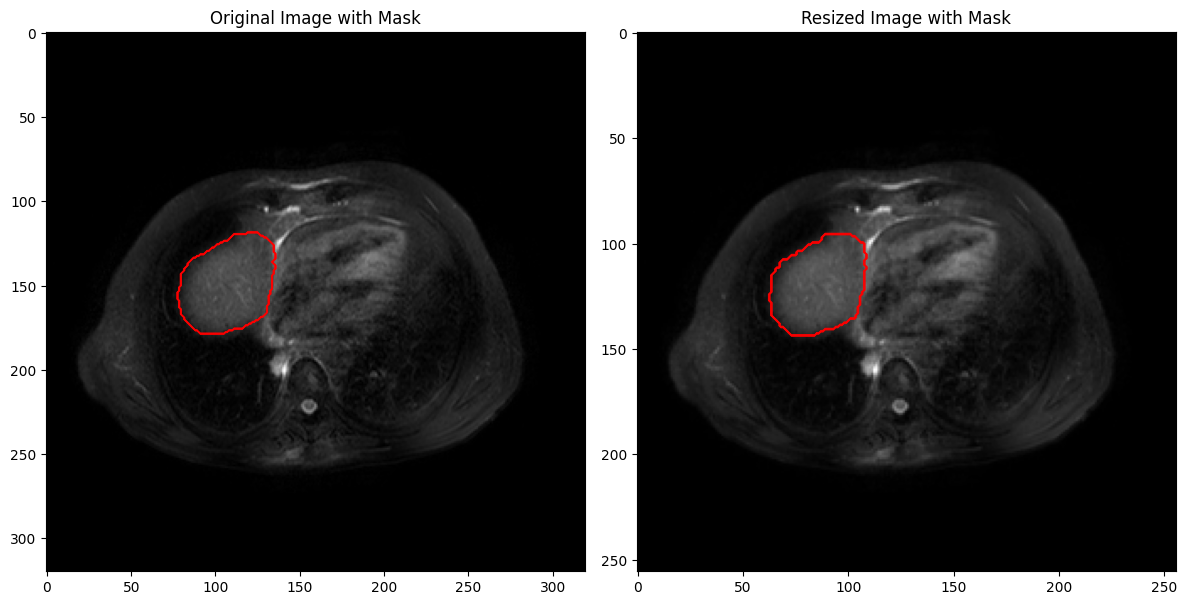

In [8]:

# Paths
original_image_folder = os.path.join(base_dir, '13', 'T2SPIR', "DICOM_anon")
resized_image_folder = os.path.join(output_path, 'resized_data', '13', 'T2SPIR',"DICOM_anon")
original_mask_folder = os.path.join(output_path, 'converted_masks', '13', 'T2SPIR')
resized_mask_folder = os.path.join(output_path, 'resized_data', '13', 'T2SPIR',"Ground")

# Load slices
# For simplicity, assume img_resized was saved as separate slices in a folder as .png or .dcm (adjust if not)
original_image_files=sorted([os.path.join(original_image_folder, f) for f in os.listdir(original_image_folder)])
resized_image_files = sorted([os.path.join(resized_image_folder, f) for f in os.listdir(resized_image_folder)])
resized_mask_files = sorted([os.path.join(resized_mask_folder, f) for f in os.listdir(resized_mask_folder)])
original_mask_files = sorted([os.path.join(original_mask_folder, f) for f in os.listdir(original_mask_folder)])

# Pick a random slice index
slice_idx = random.randint(0, len(resized_image_files) - 1)

# Load images and masks
# Original image slice (DICOM)
import pydicom
original_image_dicom = pydicom.dcmread(original_image_files[slice_idx])
print(original_image_files[slice_idx])
original_image = original_image_dicom.pixel_array

# Resized image slice
# Corrected: Use pydicom to read the resized DICOM file
ds_resized = pydicom.dcmread(resized_image_files[slice_idx])
print(resized_image_files[slice_idx])
resized_image = ds_resized.pixel_array

# Original mask
original_mask = cv2.imread(original_mask_files[slice_idx], cv2.IMREAD_UNCHANGED)
print(original_mask_files[slice_idx])
# Resized mask
resized_mask = cv2.imread(resized_mask_files[slice_idx], cv2.IMREAD_UNCHANGED)
print(resized_mask_files[slice_idx])
# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image + mask
axes[0].imshow(original_image, cmap='gray')
axes[0].contour(original_mask, colors='r', linewidths=0.5)
axes[0].set_title("Original Image with Mask")

# Resized image + mask
axes[1].imshow(resized_image, cmap='gray')
axes[1].contour(resized_mask, colors='r', linewidths=0.5)
axes[1].set_title("Resized Image with Mask")

plt.tight_layout()
plt.show()


Normalization

In [9]:
def min_max_normalize(img):
    # Compute min and max over the entire scan
    min_val = img.min()
    max_val = img.max()

    # Avoid division by zero
    if max_val - min_val == 0:
        return np.zeros_like(img)

    # Scale to 0-1
    norm_img = (img - min_val) / (max_val - min_val)
    return norm_img

In [10]:
def z_score_normalize(img):
    mean = img.mean()
    std = img.std()

    if std == 0:
        return np.zeros_like(img)

    norm_img = (img - mean) / std
    return norm_img

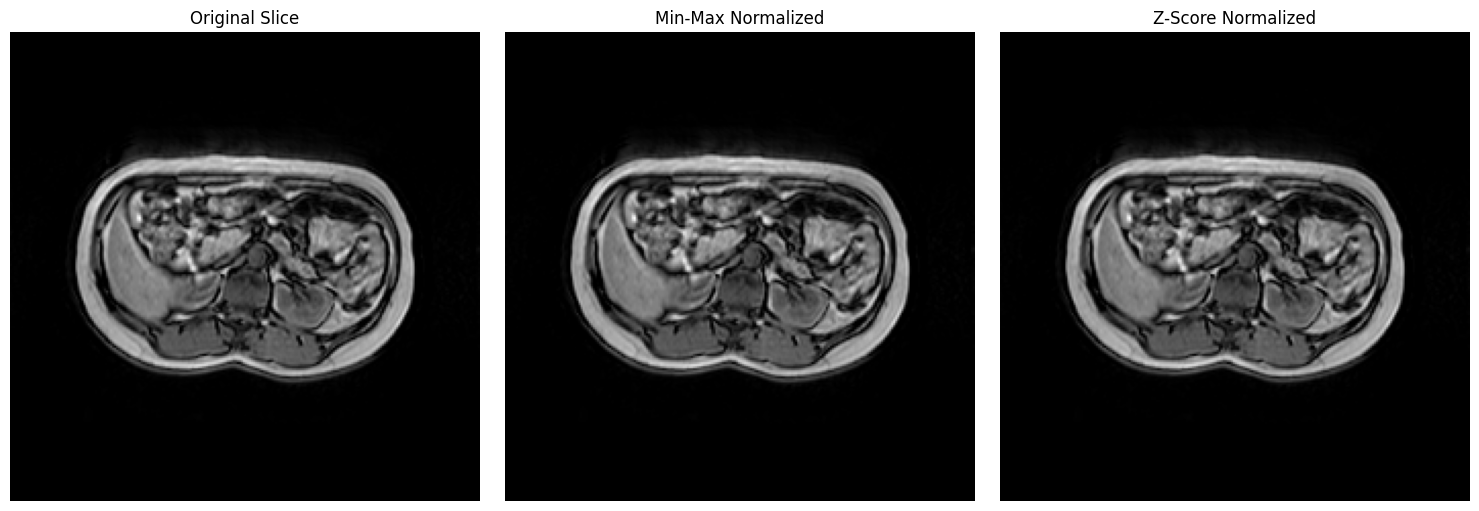

In [11]:
# Normalizing one slice
# Select a slice index (for example, middle slice)
slice_idx = img_resized.shape[2] // 2
original_slice = img_resized[:, :, slice_idx]

# Apply normalization functions
minmax_slice = min_max_normalize(original_slice)
zscore_slice = z_score_normalize(original_slice)

# Plot them side by side
# Determine global min and max for display
vmin = original_slice.min()
vmax = original_slice.max()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_slice, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title("Original Slice")
axes[0].axis('off')

axes[1].imshow(minmax_slice, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Min-Max Normalized")
axes[1].axis('off')

axes[2].imshow(zscore_slice, cmap='gray')  # z-score centered on 0
axes[2].set_title("Z-Score Normalized")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [12]:
# Afficher min, max et moyenne
print("Original slice: min =", original_slice.min(), ", max =", original_slice.max(), ", mean =", original_slice.mean())
print("Min-Max normalized: min =", minmax_slice.min(), ", max =", minmax_slice.max(), ", mean =", minmax_slice.mean())
print("Z-score normalized: min =", zscore_slice.min(), ", max =", zscore_slice.max(), ", mean =", zscore_slice.mean())


Original slice: min = 0 , max = 706 , mean = 81.22884688090737
Min-Max normalized: min = 0.0 , max = 1.0 , mean = 0.11505502391063369
Z-score normalized: min = -0.5674298579676278 , max = 4.3643831014418275 , mean = -5.157814943891843e-17


In [18]:
modalities = ["T2SPIR/DICOM_anon","T1DUAL/DICOM_anon/InPhase","T1DUAL/DICOM_anon/OutPhase"]

special_patients = ['13', '19', '2', '20', '3', '38']

output_base = os.path.join(output_path,"preprocessed_data", "min_max_normalized_images")
os.makedirs(output_base, exist_ok=True)

for patient in sorted(os.listdir(base_dir)):
    # Choose correct input folder
    if patient in special_patients:
        patient_images_path = os.path.join(output_path, "resized_data", patient)
    else:
        patient_images_path = os.path.join(base_dir, patient)

    print(f"Processing patient: {patient}")

    # Output folder for this patient
    patient_output_path = os.path.join(output_base, patient)
    os.makedirs(patient_output_path, exist_ok=True)

    for modality in modalities:
        print(f"  → Modality: {modality}")

        modality_images_path = os.path.join(patient_images_path, modality)
        if not os.path.isdir(modality_images_path):
            continue

        modality_output_path = os.path.join(output_base, modality)
        os.makedirs(modality_output_path, exist_ok=True)

        # Loop through all DICOM files
        for fname in sorted(os.listdir(modality_images_path)):
            #if not fname.lower().endswith(".dcm"):
                #continue

            file_path = os.path.join(modality_images_path, fname)

            #try:
            ds = pydicom.dcmread(file_path)
            img_array = ds.pixel_array
            #except Exception as e:
                #continue

            # Apply Min-Max Normalization
            norm_img = min_max_normalize(img_array)

            # Update DICOM
            ds.PixelData = norm_img.astype(np.float32).tobytes()
            ds.Rows, ds.Columns = norm_img.shape

            # Save output
            save_path = os.path.join(modality_output_path, fname)
            ds.save_as(save_path)



Processing patient: 1
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 10
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 13
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 15
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 19
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 2
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 20
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 21
  → Modality: T2SPIR/DICOM_

In [19]:

output_base = os.path.join(output_path,"preprocessed_data", "z_score_normalized_images")
os.makedirs(output_base, exist_ok=True)

for patient in sorted(os.listdir(base_dir)):

    # Only folders with digits → real patient folders
    if not patient.isdigit():
        continue

    # Choose correct input folder
    if patient in special_patients:
        patient_images_path = os.path.join(output_path, "resized_data", patient)
    else:
        patient_images_path = os.path.join(base_dir, patient)

    if not os.path.isdir(patient_images_path):
        continue

    print(f"Processing patient: {patient}")

    # Output folder for this patient
    patient_output_path = os.path.join(output_base, patient)
    os.makedirs(patient_output_path, exist_ok=True)

    for modality in modalities:
        print(f"  → Modality: {modality}")

        modality_images_path = os.path.join(patient_images_path, modality)
        if not os.path.isdir(modality_images_path):
            continue

        modality_output_path = os.path.join(patient_output_path, modality)
        os.makedirs(modality_output_path, exist_ok=True)

        # Loop through all DICOM files
        for fname in sorted(os.listdir(modality_images_path)):
            if not fname.lower().endswith(".dcm"):
                continue

            file_path = os.path.join(modality_images_path, fname)

            try:
                ds = pydicom.dcmread(file_path)
                img_array = ds.pixel_array
            except Exception as e:
                continue

            # Apply z_score Normalization
            norm_img = z_score_normalize(img_array)

            # Update DICOM
            ds.PixelData = norm_img.astype(np.float32).tobytes()
            ds.Rows, ds.Columns = norm_img.shape

            # Save output
            save_path = os.path.join(modality_output_path, fname)
            ds.save_as(save_path)

Processing patient: 1
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 10
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 13
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 15
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 19
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 2
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 20
  → Modality: T2SPIR/DICOM_anon
  → Modality: T1DUAL/DICOM_anon/InPhase
  → Modality: T1DUAL/DICOM_anon/OutPhase
Processing patient: 21
  → Modality: T2SPIR/DICOM_

for hyperparameters tuning, if you use a model like gridsearch you should explain why you chose that model exactly

for data augmentation for minority class (for class imbalance), see smote

Explain theoritically (from what you think) which model is expected to have better results and why

if using regularization you need to justify it (it has to make sense)